In [ ]:
# train data
!wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv

--2025-04-20 03:11:18--  https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720259 (703K) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>] 703.38K  --.-KB/s    in 0.02s   

2025-04-20 03:11:19 (36.9 MB/s) - ‘train.tsv’ saved [720259/720259]



In [ ]:
# test data
!wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv

--2025-04-20 03:11:19--  https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188749 (184K) [text/plain]
Saving to: ‘test.tsv’

test.tsv            100%[===================>] 184.33K  --.-KB/s    in 0.01s   

2025-04-20 03:11:19 (13.3 MB/s) - ‘test.tsv’ saved [188749/188749]



## Imports

In [ ]:
import time
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from torch.utils.data import DataLoader, TensorDataset
from torch.quantization import quantize_dynamic
from torch import serialization

## Dataset preparation

In [ ]:
df1 = pd.read_csv('train.tsv', delimiter = '\t', header = None)
df_test = pd.read_csv('test.tsv', delimiter = '\t', header = None)

In [ ]:
df1.columns = ["text", "label"]
df_test.columns = ["text", "label"]
df1

,text,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
6915,"painful , horrifying and oppressively tragic ,...",1
6916,take care is nicely performed by a quintet of ...,0
6917,"the script covers huge , heavy topics in a bla...",0
6918,a seriously bad film with seriously warped log...,0


In [ ]:
# 20% validation
df_train, df_val = train_test_split(df1, test_size = 0.2, random_state = 18, stratify = df1['label'])

## Constructing a MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size = 10000):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),

            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# allowing loading quantized weights from these models
serialization.add_safe_globals([MLP])
serialization.add_safe_globals([nn.Sequential, nn.Linear, nn.ReLU, nn.Dropout])

In [ ]:
model = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torchsummary.summary(model, input_size = (10000, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       5,120,512
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
Total params: 5,293,122
Trainable param

In [ ]:
parameters = sum([p.numel() for p in model.parameters()])
print(f"The total number of parameteres is {parameters}")

The total number of parameteres is 5293122


In [ ]:
del model

## Training the model

### Creating Bag of Words

In [ ]:
vectorizer = CountVectorizer(max_features = 10000, stop_words = 'english')

# train BoW
X_train = vectorizer.fit_transform(df_train['text']).toarray()
y_train = df_train['label'].values

# validation BoW
X_val = vectorizer.transform(df_val['text']).toarray()
y_val = df_val['label'].values

# test BoW
X_test = vectorizer.transform(df_test['text']).toarray()
y_test = df_test['label'].values

In [ ]:
# tensors
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)

X_val_tensor = torch.tensor(X_val, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val, dtype = torch.long)

X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

# DataLoaders
b = 256
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size = b, shuffle = True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size = b)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size = b)

### Torch training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = MLP()
model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
best_val_acc = 0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for epoch in range(1, 11):
    print(f"Epoch {epoch}")
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    # training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss.append(running_loss / total)
    train_acc.append(correct / total)

    # validation
    model.eval()
    running_val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

        val_loss.append(running_val_loss / val_total)
        val_acc.append(val_correct / val_total)

        if val_correct/val_total > best_val_acc:
            best_val_acc = val_correct/val_total
            torch.save(model.state_dict(), 'checkpoint.pt')

    print(f"Train loss: {(running_loss / total ):.4f}")
    print(f"Validation loss: {(running_val_loss / val_total ):.4f}")
    print("----------------")
    print()

Epoch 1
Train loss: 0.6890
Validation loss: 0.6660
----------------

Epoch 2
Train loss: 0.4893
Validation loss: 0.5867
----------------

Epoch 3
Train loss: 0.1752
Validation loss: 0.6925
----------------

Epoch 4
Train loss: 0.0646
Validation loss: 1.0459
----------------

Epoch 5
Train loss: 0.0253
Validation loss: 1.3760
----------------

Epoch 6
Train loss: 0.0172
Validation loss: 1.4648
----------------

Epoch 7
Train loss: 0.0102
Validation loss: 1.6401
----------------

Epoch 8
Train loss: 0.0069
Validation loss: 1.8367
----------------

Epoch 9
Train loss: 0.0065
Validation loss: 1.9646
----------------

Epoch 10
Train loss: 0.0062
Validation loss: 2.0873
----------------



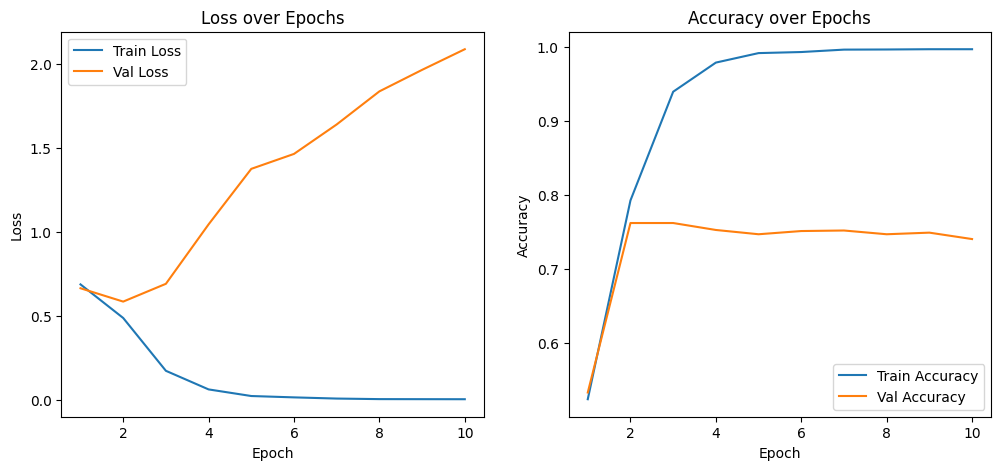

In [ ]:
epochs = range(1, 11)
plt.figure(figsize = (12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label = 'Train Loss')
plt.plot(epochs, val_loss, label = 'Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label = 'Train Accuracy')
plt.plot(epochs, val_acc, label = 'Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

The given model architecture overfits on our dataset

## Quantization

### Quantization with INT8

In [ ]:
del model

In [ ]:
model = MLP()
model.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [ ]:
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
from torch.ao.quantization import quantize_dynamic

In [ ]:
quantized_model = quantize_dynamic(
    model, {nn.Linear}, dtype = torch.qint8)

In [ ]:
torch.save(quantized_model, "quantized_model.pt")

### Half quantization

In [ ]:
model = MLP()
model.load_state_dict(torch.load("checkpoint.pt"))
model = model.half()

torch.save(model.state_dict(), "half_model.pt")
del model

## Comparing quantization techniques

### Original model

In [ ]:
def evaluate_original_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = MLP().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            # print(inputs.dtype)
            labels = labels.to(device)
            # print(next(model.parameters()).dtype)
            start_time = time.perf_counter()
            outputs = model(inputs)
            inference_times.append(time.perf_counter() - start_time)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.to("cpu")
    del model

    return {
        'Accuracy': round(100 * correct / total, 2),
        'Storage (MB)': round(os.path.getsize(model_path) / (1024**2), 2),
        'Avg Inference (ms)': round(sum(inference_times)/len(inference_times)*1000, 3)
    }

In [ ]:
evaluate_original_model(r"/content/checkpoint.pt")

{'Accuracy': 78.36, 'Storage (MB)': 20.2, 'Avg Inference (ms)': 0.517}

### INT8 Quantized model

In [ ]:
def evaluate_int8_model(model_path = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = torch.load(model_path, map_location = "cpu", weights_only = False)
    model.eval()

    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to("cpu")
            labels = labels.to("cpu")

            start_time = time.perf_counter()
            outputs = model(inputs)
            inference_times.append(time.perf_counter() - start_time)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return {
        'Accuracy': round(100 * correct / total, 2),
        'Storage (MB)': round(os.path.getsize(model_path) / (1024**2), 2),
        'Avg Inference (ms)': round(sum(inference_times) / len(inference_times) * 1000, 3)
    }

In [ ]:
evaluate_int8_model(r"/content/quantized_model.pt")

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:410: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


{'Accuracy': 78.42, 'Storage (MB)': 5.06, 'Avg Inference (ms)': 22.855}

### Half model

In [ ]:
def evaluate_half_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = MLP().half().to(device)
    model.load_state_dict(torch.load(model_path, weights_only = False))
    model.eval()

    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.half().to(device)
            # print(inputs.dtype)
            labels = labels.to(device)
            # print(next(model.parameters()).dtype)
            start_time = time.perf_counter()
            outputs = model(inputs)
            inference_times.append(time.perf_counter() - start_time)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return {
        'Accuracy': round(100 * correct / total, 2),
        'Storage (MB)': round(os.path.getsize(model_path) / (1024**2), 2),
        'Avg Inference (ms)': round(sum(inference_times)/len(inference_times)*1000, 3)
    }

In [ ]:
evaluate_half_model(r"/content/half_model.pt")

{'Accuracy': 78.36, 'Storage (MB)': 10.1, 'Avg Inference (ms)': 13.191}